In [1]:
import pandas as pd

In [2]:
pd.__version__

'0.24.2'

In [3]:
import numpy as np
import pandas as pd
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
from scipy import special
from scipy import optimize

/home/sangrey/anaconda3/envs/volprice2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [5]:
vl.__version__

'0.05.01-py37_0'

In [6]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [7]:
vl.__version__

'0.05.01-py37_0'

In [8]:
kharpov = True

In [9]:
if kharpov:
    true_params = {'zeta2': 1.7680, 
               'zeta1': -10,
               'phi': -.4,
               'log_scale': np.log(3.94128e-3),
                'logit_rho': special.logit(.81),
#                'logit_rho': special.logit(.5)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
    true_params = {'zeta2': 0.3, 
               'zeta1': -15,
               'phi': -0.3,
               'log_scale': np.log(3.94128e-3),
                'logit_rho': special.logit(0.81)
                }
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
    
time_dim = 10_000
sim_dim = 500
innov_dim = 2000

In [10]:
bounds = {'zeta1': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': 0, 'min':-.5, 'dim':4}, 
          'zeta2': {'max':2.5, 'min': 0, 'dim':10}}

In [11]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          zeta2=true_params['zeta2'], logit_rho=true_params['logit_rho'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            zeta1=true_params['zeta1'],zeta2=true_params['zeta2'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            zeta1=true_params['zeta1'],zeta2=true_params['zeta2'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['xi'] = 1 - true_params['phi']**2                                           

In [12]:
total_true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413,
 'psi': -3.6707749357196766,
 'beta': 4.645711998790369,
 'gamma': 0.009979157894613974,
 'xi': 0.84}

In [13]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   zeta1=true_params['zeta1'], phi=true_params['phi'], zeta2=true_params['zeta2'])

{'return_mean': 0.023073993243512246,
 'return_var': 0.021049962065349113,
 'vol_mean': 0.01343146736842106,
 'vol_var': 0.00027861670373584524}

In [14]:
data = vl.simulate_data(time_dim=time_dim, simulate_heavy=True, **true_params)

In [15]:
data.loc['2005', ['mu', 'rv']].plot()

In [16]:
def next_mu(omega_r, alpha_r, beta_r, previous_RV, previous_mu):
    return omega_r + alpha_r * previous_RV + beta_r * previous_mu

In [17]:
def compute_mu(omega_r, alpha_r, beta_r, RV, initial_mu):
    
    mu = [initial_mu]
    for vol in RV.iloc[:-1]:
        mu.append(next_mu(omega_r, alpha_r, beta_r, vol, mu[-1]))
        
    result = pd.DataFrame(mu, index=RV.index, columns=['mu'])
    
    return result

In [18]:
mu1 = data.iloc[:int(data.size**.5)].mean()['rv']

In [19]:
def heavy_loss(params, vol=data.rv, initial_mu=mu1):
    
    omega_r, alpha_r, beta_r = params
    mu = compute_mu(omega_r, alpha_r, beta_r, vol, initial_mu=mu1)
    first_val =  np.log(mu.iloc[1:]).sum()
    second_val = (vol.T / mu.T).T.iloc[1:].sum()
    
    # We want to minimize this. 
    return .5 * ((first_val + second_val)).item()

In [20]:
def estimate_param_with_heavy(data):
    
    mu1 = data.iloc[:int(data.size**.5)].mean()['rv']
    
    heavy_loss2 = partial(heavy_loss, mu1=mu1, vol=data.rv)
    
    results = optimize.minimize(heavy_loss, x0=(0, .9, 0), bounds=((None, None), (0, 1), (0, 1)),
                            method='L-BFGS-B')

    data2 = data.join(compute_mu(*results.x, RV=data.rv, initial_mu=mu1).rename(columns={'mu':'mu_hat'}))
    
    return data2

In [21]:
# data2 = estimate_param_with_heavy(data)

In [22]:
# results = optimize.minimize(heavy_loss, x0=(0, .9, 0), bounds=((None, None), (0, 1), (0, 1)),
#                             method='L-BFGS-B')

# data2 = data.join(compute_mu(*results.x, RV=data.rv, initial_mu=mu1).rename(columns={'mu':'mu_hat'}))

In [23]:
data.describe()

mu            rv           rtn
count  10000.000000  1.000000e+04  10000.000000
mean       0.013869  1.439027e-02      0.022964
std        0.017212  3.687025e-02      0.227365
min        0.000010  3.551069e-11     -3.373559
25%        0.002369  3.572667e-04     -0.016033
50%        0.007776  2.561622e-03      0.017704
75%        0.018870  1.181795e-02      0.065249
max        0.143820  9.162817e-01      4.178803

In [24]:
# data2[['mu', 'rv', 'mu_hat']].loc['2005-01':'2005-06'].plot()

In [25]:
total_true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413,
 'psi': -3.6707749357196766,
 'beta': 4.645711998790369,
 'gamma': 0.009979157894613974,
 'xi': 0.84}

In [26]:
true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413}

In [27]:
special.expm1(true_params['logit_rho'])

3.2631578947368434

In [28]:
total_true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413,
 'psi': -3.6707749357196766,
 'beta': 4.645711998790369,
 'gamma': 0.009979157894613974,
 'xi': 0.84}

## We start by examining the distributions of simulated data

In [29]:
# data2.corr()

In [30]:
data.head()

mu        rv       rtn
2000-01-01  0.001775  0.004678  0.083513
2000-01-02  0.008099  0.000264  0.027342
2000-01-03  0.008552  0.006190  0.001590
2000-01-04  0.012664  0.000721  0.011911
2000-01-05  0.010498  0.005938  0.056862

In [31]:
data.var()

mu     0.000296
rv     0.001359
rtn    0.051695
dtype: float64

In [32]:
# vl.compute_vol_gmm(data2.mu_hat)

In [33]:
# omega, omega_cov = vl.estimate_params(data2.rename(columns={'mu_hat':'vol'}))

In [34]:
# total_est, total_cov = vl.estimate_params_strong_id(data2.rename(columns={'rv':'vol'}), bounds=bounds)

In [35]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.rv.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [36]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

mu        rv       rtn
mu   0.000296  0.000317  0.000073
rv   0.000317  0.001359 -0.003776
rtn  0.000073 -0.003776  0.051695

In [37]:
total_true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413,
 'psi': -3.6707749357196766,
 'beta': 4.645711998790369,
 'gamma': 0.009979157894613974,
 'xi': 0.84}

In [38]:
data.describe()

mu            rv           rtn
count  10000.000000  1.000000e+04  10000.000000
mean       0.013869  1.439027e-02      0.022964
std        0.017212  3.687025e-02      0.227365
min        0.000010  3.551069e-11     -3.373559
25%        0.002369  3.572667e-04     -0.016033
50%        0.007776  2.561622e-03      0.017704
75%        0.018870  1.181795e-02      0.065249
max        0.143820  9.162817e-01      4.178803

## I now estimate all of the parameters

In [39]:
# vl.compute_init_constants(data2.mu_hat)

In [40]:
data_arr = [vl.simulate_data(time_dim=time_dim, simulate_heavy=True, 
                             **true_params).rename(columns={'mu_hat':'vol'})  for _ in tqdm.trange(sim_dim)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.71it/s]


In [41]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [42]:
with Pool(8) as pool:
    data_with_mu = list(tqdm.tqdm(pool.imap_unordered(estimate_param_with_heavy, data_arr),
                                      total=len(data_arr)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [19:56:48<00:00, 143.62s/it]


In [43]:
data_with_mu[0].head()

mu        rv       rtn    mu_hat
2000-01-01  0.006599  0.000285  0.154526  0.012935
2000-01-02  0.003755  0.005899  0.102327  0.009764
2000-01-03  0.004532  0.001493  0.029086  0.009678
2000-01-04  0.008509  0.002402 -0.041490  0.008302
2000-01-05  0.004263  0.002282  0.012483  0.007804

In [44]:
data_arr2 = [data.rename(columns={'mu_hat':'vol'}) for data in data_with_mu]

In [45]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm(pool.imap_unordered(estimator, data_arr2),
                                      total=len(data_arr2)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:23<00:00,  2.46it/s]


In [46]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.shape[1])

In [47]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data_arr2[idx].vol,
                                                   log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for idx in tqdm.tqdm(range(len(data_arr2)))])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 468.48it/s]


In [48]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'xi','psi']


In [49]:
total_true_params


{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413,
 'psi': -3.6707749357196766,
 'beta': 4.645711998790369,
 'gamma': 0.009979157894613974,
 'xi': 0.84}

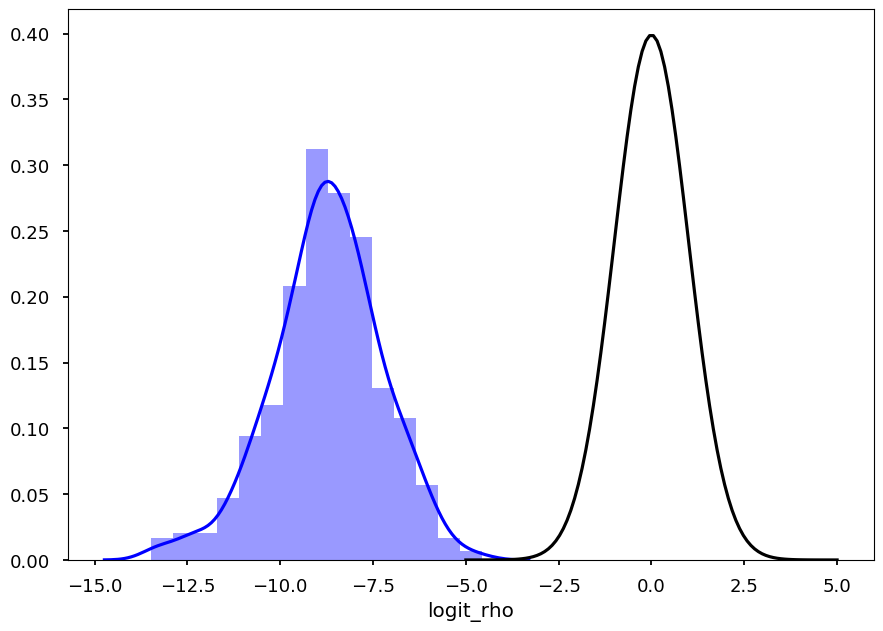

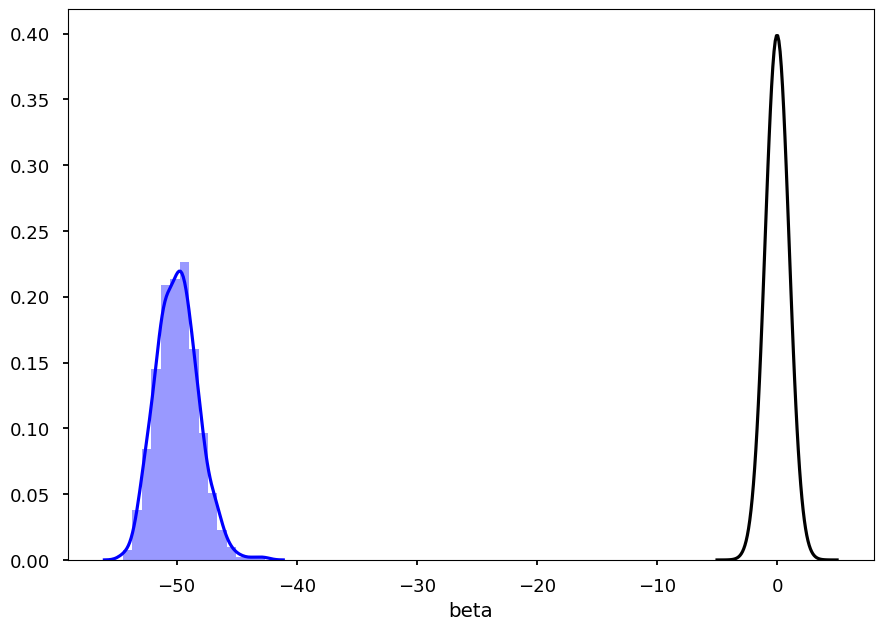

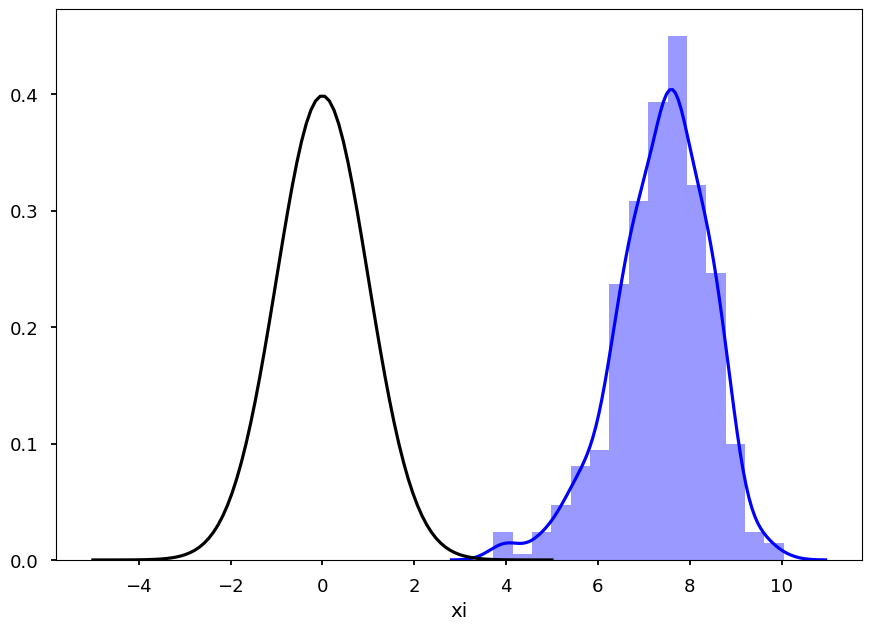

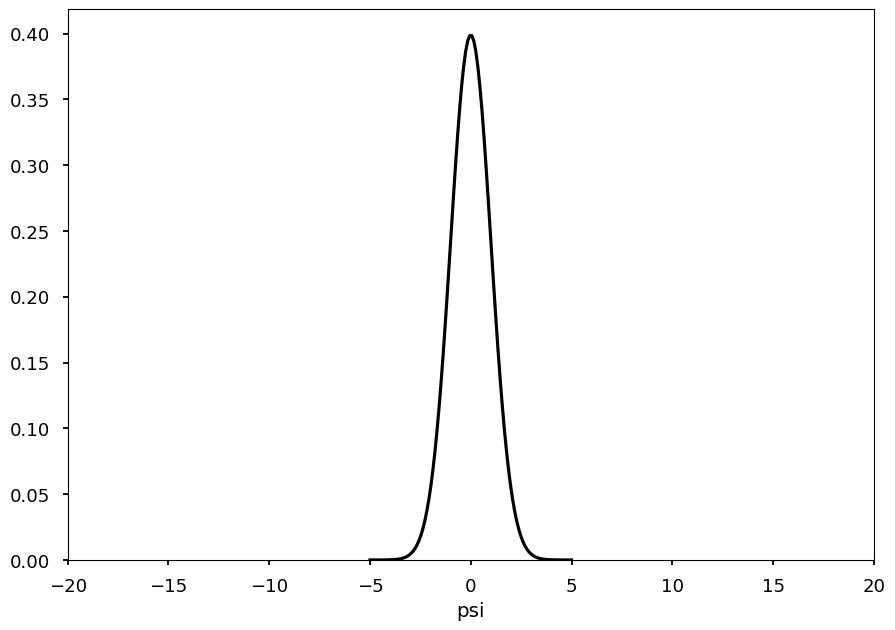

In [50]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='blue')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [51]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['zeta1'], total_true_params['zeta2']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'xi']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['xi'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [52]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm(est_arr)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 797.46it/s]


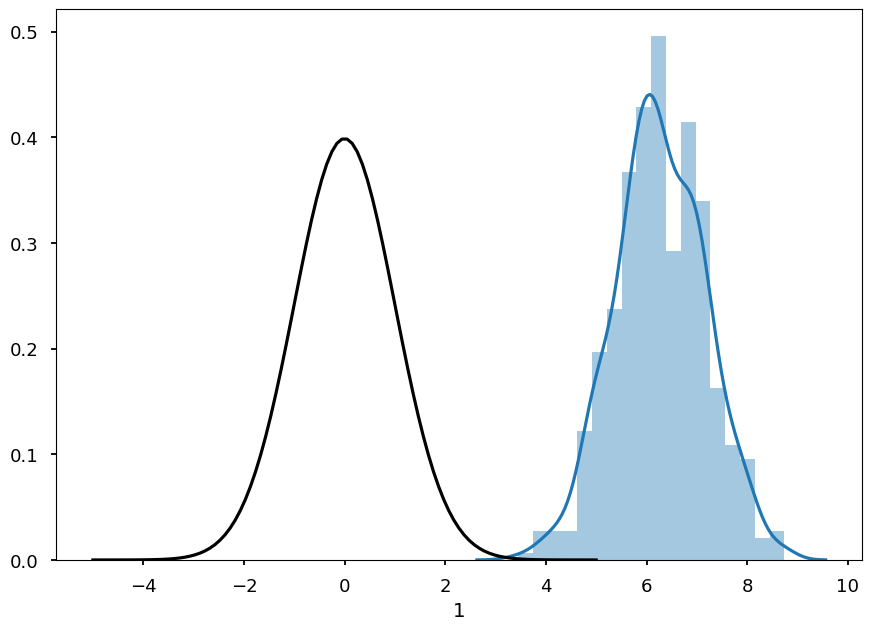

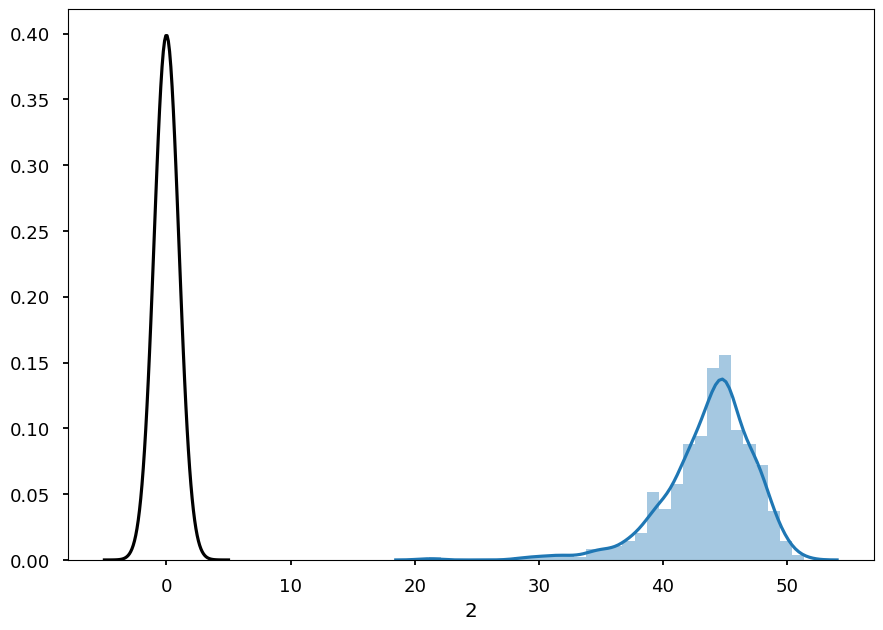

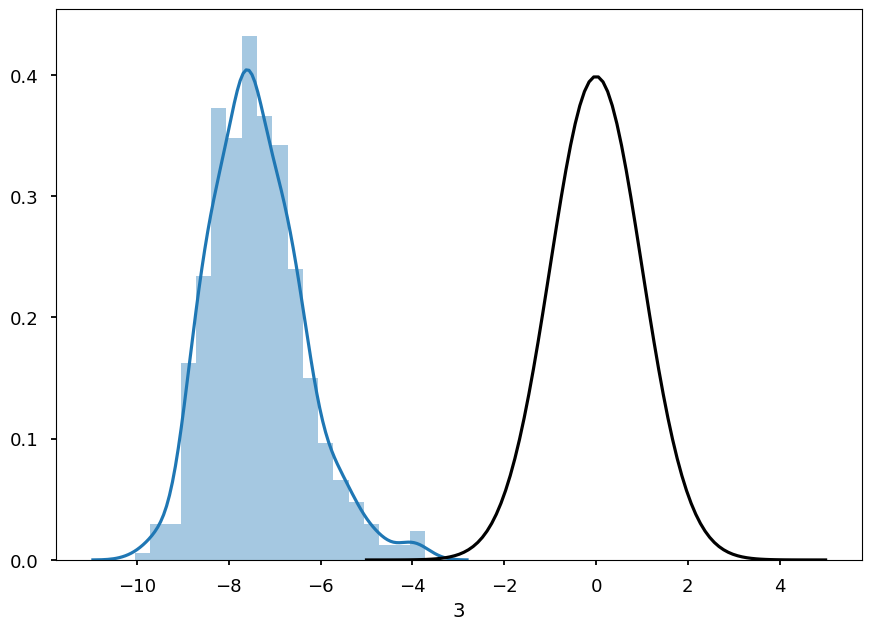

In [53]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [54]:
bounds

{'zeta1': {'max': 0, 'min': -25, 'dim': 32},
 'phi': {'max': 0, 'min': -0.5, 'dim': 4},
 'zeta2': {'max': 2.5, 'min': 0, 'dim': 10}}

In [55]:
f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".png"

'../doc/figures/psi_est_2000_minus_0_point_40.png'

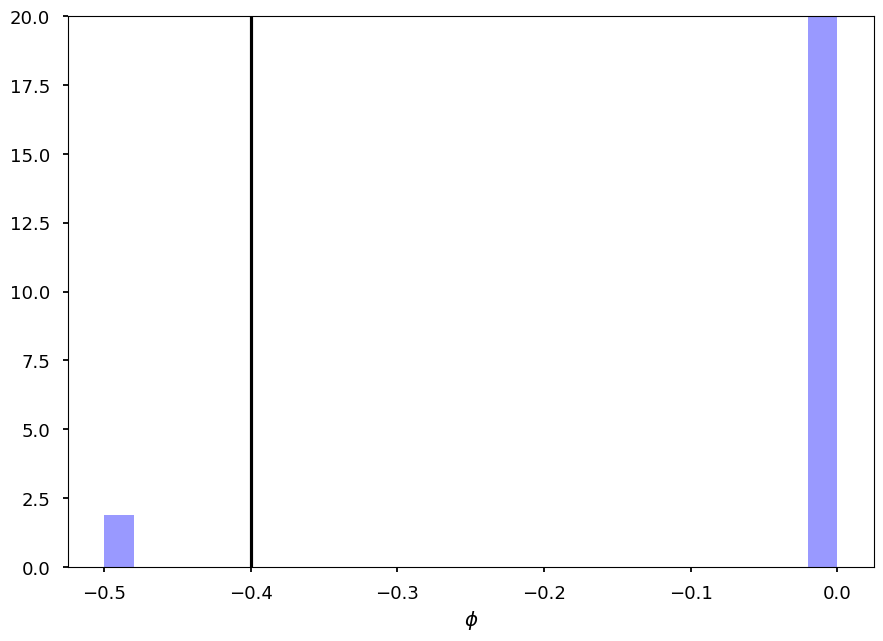

In [56]:
for name in ['phi', 'zeta1', 'zeta2']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='blue', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
    ax.axvline(true_params[name], color='black')
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".png", pad_inches=0,
                bbox_inches='tight')

# I now compute the robust conditional QLR statistic 

In [57]:
true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413}

In [58]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['zeta1'], true_params['zeta2']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [59]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['zeta1'], true_params['zeta2']]

In [60]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 945.41it/s]


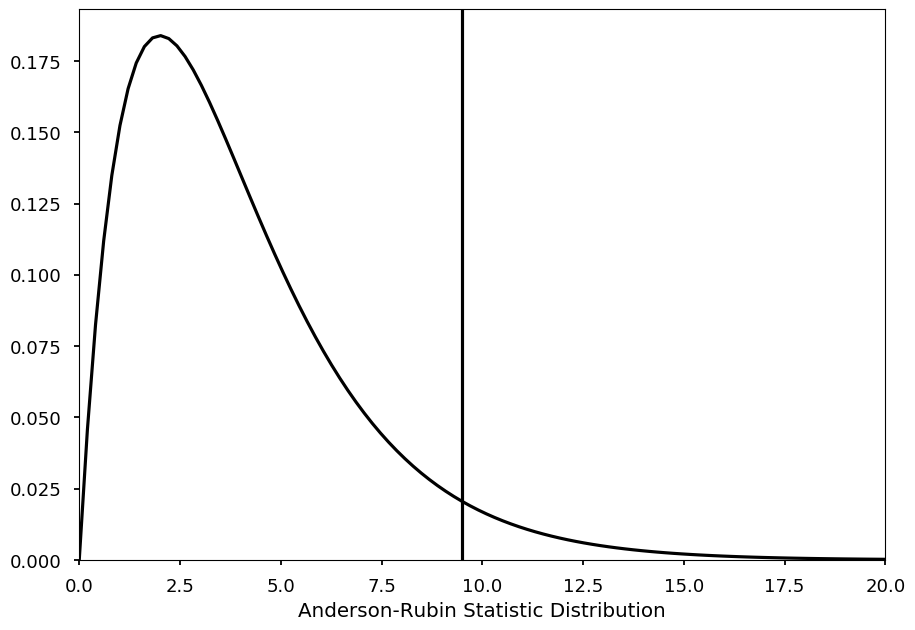

In [61]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')

    sns.distplot(ar_results, ax=ax)
    

In [62]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    1.0
dtype: float64

In [63]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [64]:
# compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
#                                                            true_params['theta']],
#                       innov_dim=100, alpha=None, robust_quantile=True, bounds=bounds)
# total=min(100, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [65]:
# fig, ax = mpl.pyplot.subplots()
# sns.distplot(np.ravel(results.iloc[:,1:]), ax=ax, color='green')
# sns.distplot(np.ravel(ar_results), ax=ax, color='red')
# sns.distplot(np.ravel(results.iloc[:,0]), ax=ax, color='purple')

In [66]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)
# ar_pit = stats.chi2.cdf(ar_results, df=4)

In [67]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# cdpm.pit_plot(ar_pit, ax=ax, color='green', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='ar')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [82]:


returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.10, 
                                        robust_quantile=True, bounds=bounds)

  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
  1%|▊                                                                                                                                    | 3/500 [01:44<3:19:07, 24.04s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
  1%|█                                                                                                                                    | 4/500 [01:45<2:03:34, 14.95s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
  2%|██▏                                                                                                                                

 14%|██████████████████▍                                                                                                                   | 69/500 [04:03<12:48,  1.78s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 14%|██████████████████▊                                                                                                                   | 70/500 [04:04<09:44,  1.36s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 15%|███████████████████▌                                                                                                                  | 73/500 [04:13<18:15,  2.57s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 15%|███████████████████▊                                                                                                               

 29%|██████████████████████████████████████▌                                                                                              | 145/500 [06:46<15:32,  2.63s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 30%|███████████████████████████████████████▎                                                                                             | 148/500 [06:50<11:55,  2.03s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 30%|███████████████████████████████████████▋                                                                                             | 149/500 [06:51<09:39,  1.65s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 30%|████████████████████████████████████████▍                                                                                          

 45%|███████████████████████████████████████████████████████████▌                                                                         | 224/500 [09:28<06:00,  1.31s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 45%|███████████████████████████████████████████████████████████▊                                                                         | 225/500 [09:35<14:01,  3.06s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 45%|████████████████████████████████████████████████████████████                                                                         | 226/500 [09:36<11:33,  2.53s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 45%|████████████████████████████████████████████████████████████▍                                                                      

 60%|███████████████████████████████████████████████████████████████████████████████▎                                                     | 298/500 [12:07<07:36,  2.26s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 60%|███████████████████████████████████████████████████████████████████████████████▌                                                     | 299/500 [12:12<09:35,  2.86s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 61%|████████████████████████████████████████████████████████████████████████████████▌                                                    | 303/500 [12:16<06:03,  1.85s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                 

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 379/500 [15:00<04:46,  2.36s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 381/500 [15:02<03:22,  1.70s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 384/500 [15:08<03:45,  1.94s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 458/500 [17:44<01:04,  1.55s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 467/500 [18:05<01:09,  2.12s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 471/500 [18:13<01:05,  2.25s/it]WARNING:root:Some of the differences between the true and the
                        minimized value are negative.
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     

In [96]:
robust_qlr_stat = np.percentile(returnval.qlr_stat, 90)

In [97]:
true_params['phi']

-0.4

In [98]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [99]:
true_params

{'zeta2': 1.768,
 'zeta1': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.4500101755059986,
 'log_both': -5.97088622074413}

In [100]:
time_dim

10000

In [101]:
returnval = pd.read_json(filename)

In [102]:
print(filename)

../results/reject_prop_kharpov_2000_-0.4_10000.tmp.json


In [103]:
returnval.mean()

qlr_stat               890.097481
robust_qlr_qauntile      5.771375
robust                   1.000000
standard                 1.000000
dtype: float64

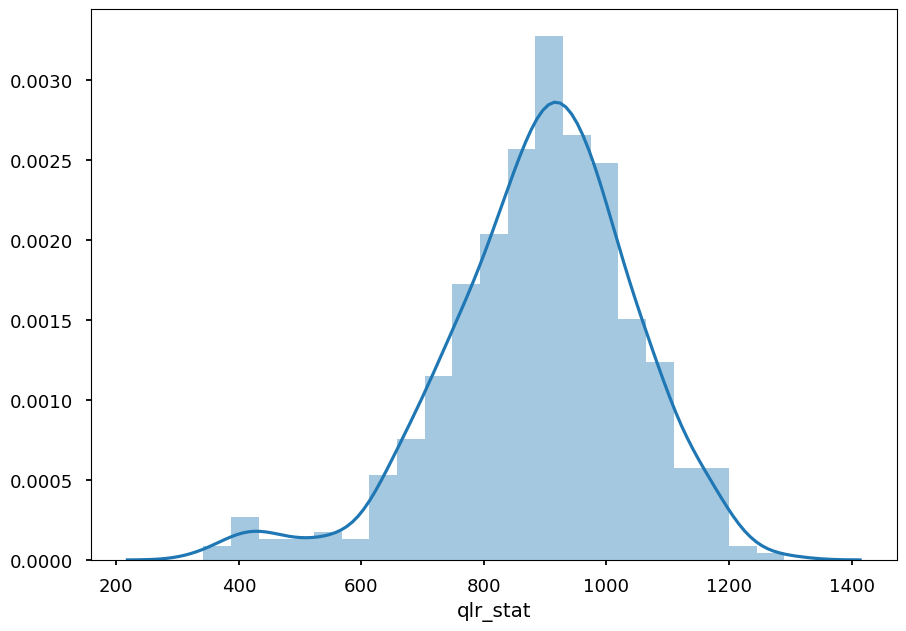

In [104]:
sns.distplot(returnval.qlr_stat)

In [105]:
#returnval.query('robust_qlr_qauntile < @robust_qlr_stat').mean()

In [106]:
filename

'../results/reject_prop_kharpov_2000_-0.4_10000.tmp.json'

In [107]:
returnval.mean()

qlr_stat               890.097481
robust_qlr_qauntile      5.771375
robust                   1.000000
standard                 1.000000
dtype: float64

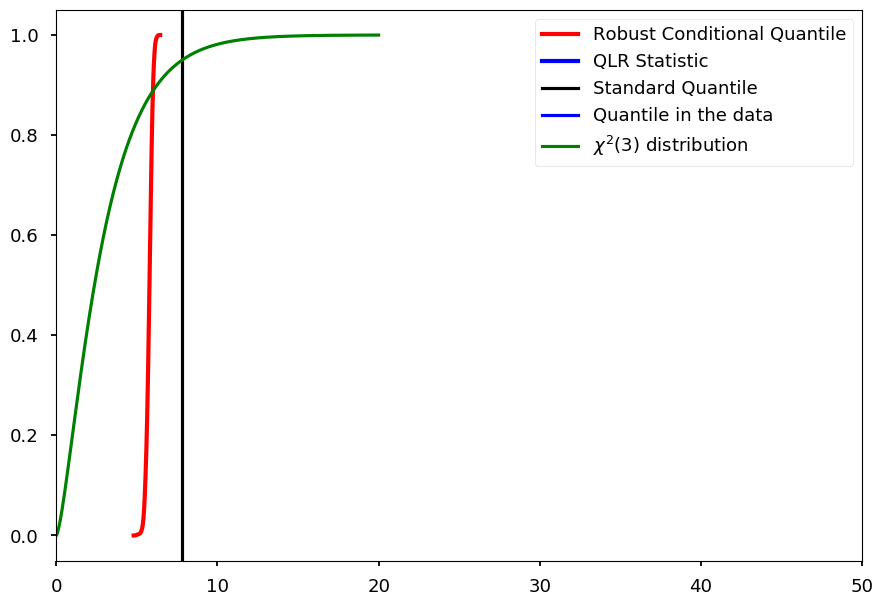

In [108]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)